### **Activate the TPU**

In [ ]:
use_tpu = True
import os
if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

# TPU address
tpu_address = TF_MASTER

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)


#### *Un investissement dans la connaissance est plus rentable* $Benjamin- Franklin$ 

In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import tensorflow as tf
import pickle

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
#strategy = tf.distribute.MirroredStrategy()

batch_size = 32
epochs = 50
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=15, verbose=1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importation de la clean data**

### Image data

In [ ]:
X= np.load('/content/drive/MyDrive/Data_PS3/Data_normalized_array/clean_data.npy')
Y_= np.load('/content/drive/MyDrive/Data_PS3/Data_normalized_array/clean_labels.npy')

In [ ]:
Y=tf.keras.utils.to_categorical(Y_, num_classes=2)

### tabular data

In [ ]:
X_tabular= np.load('/content/drive/MyDrive/Data_PS3/Data_normalized_array/clean_tabular_data.npy')
Y_tabular= np.load('/content/drive/MyDrive/Data_PS3/Data_normalized_array/clean_tabular_label.npy')

In [ ]:
import seaborn as sns

In [ ]:
Y_tabular.shape

(5300,)

In [ ]:
list(Y_tabular).count(0)

2079

In [ ]:
list(Y_tabular).count(1)

3221

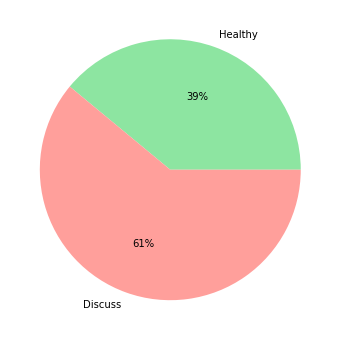

In [ ]:
#define data
data = [round(2079/5300, 2), round(3221/5300, 2)]
labels = ['Healthy', 'Discuss']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[2:5]

#create pie chart
plt.figure(figsize=(6,6))
plt.pie(data, labels = labels, colors = colors, autopct='%.000f%%')
plt.savefig('pie_plot_processed distribution')
plt.show()


-------------------------------------------------------------------------------
#### Fonction need to do easy complementary task after model training
--------------------------------------------------------------------------------------

In [ ]:
def save_fold_vectors_deep(histories, folds_y, folds_y_pred, model):
  path1 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/'+ model +"/histories__vf.npy"
  path2 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/'+ model +"/folds_y_vf.npy"
  path3 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/'+ model +"/folds_y_pred_vf.npy"
  np.save(path1, np.array(histories))
  np.save(path2, np.array(folds_y))
  np.save(path3, np.array(folds_y_pred))

def save_fold_vectors_tabular(folds_yt, folds_y_predt, folds_y_pred_probat, model):
  path1 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelTabular/'+ model +"/folds_yt__vf.npy"
  path2 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelTabular/'+ model +"/folds_y_predt_vf.npy"
  path3 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelTabular/'+ model +"/folds_y_pred_probat_vf.npy"
  np.save(path1, np.array(folds_yt))
  np.save(path2, np.array(folds_y_predt))
  np.save(path3, np.array(folds_y_pred_probat))


In [ ]:
def load_save_vector_deep(model):
  path2 ='/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/' + model + "/folds_y_vf.npy"
  path3 ='/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/' + model + "/folds_y_pred_vf.npy"
  return  np.load(path2), np.load(path3)

def load_save_vector_tabular(model):
  path1 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelTabular/'+ model +"/folds_yt__vf.npy"
  path2 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelTabular/'+ model +"/folds_y_predt_vf.npy"
  path3 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelTabular/'+ model +"/folds_y_pred_probat_vf.npy"
  return  np.load(path1), np.load(path2), np.load(path3)

In [ ]:
def load_histories(model):
  path = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/'+ model +"/histories__vf.npy"
  return np.load(path)

In [ ]:
def model_deep_metric(model):
  ACCURACY, RECALL, PRECISION, F1_SCORE, ROCAUC  = [], [], [], [], []

  fold_y_deep, fold_y_pred_deep = load_save_vector_deep(model)
  
  # prediction per fold
  prediction_fold=[np.argmax(fold, axis=1) for fold in fold_y_pred_deep]
  # The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
  y_fold = [np.argmax(fold, axis=1) for fold in fold_y_deep]

  for pred, y in zip(prediction_fold, y_fold):
    ACCURACY.append(accuracy_score(pred, y))
    RECALL.append(recall_score(pred, y))
    PRECISION.append(precision_score(pred, y))
    F1_SCORE.append(f1_score(pred, y))
    ROCAUC.append(roc_auc_score(pred, y))

  return ACCURACY, RECALL, PRECISION, F1_SCORE, ROCAUC



def model_tabular_metric(model):
  ACCURACY, RECALL, PRECISION, F1_SCORE, ROCAUC  = [], [], [], [], []

  fold_yt, fold_y_predt, folds_y_pred_probat = load_save_vector_tabular(model)
  
  for pred, y in zip(fold_y_predt, fold_yt):
    ACCURACY.append(accuracy_score(pred, y))
    RECALL.append(recall_score(pred, y))
    PRECISION.append(precision_score(pred, y))
    F1_SCORE.append(f1_score(pred, y))
    ROCAUC.append(roc_auc_score(pred, y))

  return ACCURACY, RECALL, PRECISION, F1_SCORE, ROCAUC


In [ ]:
def agregation(fold_deep, fold_tab, option='avg'):
  
  fold_agregation = []

  if option == 'avg':
    for list1, list2 in zip(fold_deep, fold_tab):
      result = []
      for fold_d, fold_t in zip(list1, list2):
        k = [np.mean([fold_d[0], fold_t[0]]), np.mean([fold_d[1], fold_t[1]])]
        result.append(k)
      fold_agregation.append(result)
  
  elif option == 'max':
    for list1, list2 in zip(fold_deep, fold_tab):
      result = []
      for fold_d, fold_t in zip(list1, list2):
        k = [max(fold_d[0], fold_t[0]), max(fold_d[1], fold_t[1])]
        result.append(k)
      fold_agregation.append(result)
  
  else:
    for list1, list2 in zip(fold_deep, fold_tab):
      result = []
      for fold_d, fold_t in zip(list1, list2):
        k = fold_d + fold_t
        result.append(k)
      fold_agregation.append(result)

  return fold_agregation
    

In [ ]:
def save_fold_agregation(model_deep, model_tabular):
  fold_y_deep, fold_y_pred_deep = load_save_vector_deep(model_deep)
  fold_y_tab, fold_y_pred_tab, fold_y_pred_proba_tab =load_save_vector_tabular(model_tabular)

  avg_agreation = agregation(fold_y_pred_deep, fold_y_pred_proba_tab, option='avg')
  max_agreation = agregation(fold_y_pred_deep, fold_y_pred_proba_tab, option='max')
  sum_agreation = agregation(fold_y_pred_deep, fold_y_pred_proba_tab, option='sum')

  path1 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelFusion/'+ model_deep + '+' + model_tabular + "/folds_y_vf.npy"
  path2 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelFusion/'+ model_deep + '+' + model_tabular + "/avg_agreation_vf.npy"
  path3 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelFusion/'+ model_deep + '+' + model_tabular + "/max_agreation_vf.npy"
  path4 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelFusion/'+ model_deep + '+' + model_tabular + "/sum_agreation_vf.npy"
  
  np.save(path1, fold_y_deep)
  np.save(path2, np.array(avg_agreation))
  np.save(path3, np.array(max_agreation))
  np.save(path4, np.array(sum_agreation))



In [ ]:
def load_fold_agregation(model_deep, model_tabular):
  path1 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelFusion/'+ model_deep + '+' + model_tabular + "/folds_y_vf.npy"
  path2 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelFusion/'+ model_deep + '+' + model_tabular + "/avg_agreation_vf.npy"
  path3 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelFusion/'+ model_deep + '+' + model_tabular + "/max_agreation_vf.npy"
  path4 = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelFusion/'+ model_deep + '+' + model_tabular + "/sum_agreation_vf.npy"
  
  return np.load(path1), np.load(path2), np.load(path3), np.load(path3)


In [ ]:
def performance_fusion(model_deep, model_tabular, option='avg'):
  
  ACCURACY, RECALL, PRECISION, F1_SCORE, ROCAUC  = [], [], [], [], []

  folds_y, avg_agregation_fold, max_agregation_fold, sum_agregation_fold = load_fold_agregation(model_deep, model_tabular)
  
  y_fold = [np.argmax(fold, axis=1) for fold in folds_y]

  if option == 'avg' :
    prediction_fold=[np.argmax(fold, axis=1) for fold in avg_agregation_fold]
  
  elif option == "max":
    prediction_fold=[np.argmax(fold, axis=1) for fold in max_agregation_fold]
  
  else:
    prediction_fold=[np.argmax(fold, axis=1) for fold in sum_agregation_fold]


  for pred, y in zip(prediction_fold, y_fold):
    ACCURACY.append(accuracy_score(pred, y))
    RECALL.append(recall_score(pred, y))
    PRECISION.append(precision_score(pred, y))
    F1_SCORE.append(f1_score(pred, y))
    ROCAUC.append(roc_auc_score(pred, y))
  
  return ACCURACY, RECALL, PRECISION, F1_SCORE, ROCAUC


In [ ]:
def save_avg(data ,name,model):
  data = pd.DataFrame(data).mean(axis = 0).to_list()
  path = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/'+ model + '/' + name + '.npy'
  np.save(path, data)

def get_histories_lists(historie):
  accur , val_accur = [] , []
  loss , val_loss = [] , []
  for hist in historie:
    accur.append(hist["accuracy"])
    val_accur.append(hist["val_accuracy"])
    loss.append(hist["loss"])
    val_loss.append(hist["val_loss"])
  return accur,val_accur,loss,val_loss

def get_avg_histories(model):
  names = ["accuracy","val_accuracy","loss","val_loss"]
  historie = load_histories(model)
  for name,item in zip(names,get_histories_lists(historie)):
    save_avg(item,name,model)

def get_vectors(metric):
  models = ["vgg16", "vgg19", "resNet50", "inceptionResNet","inceptionV3","xception","denseNet","mobileNet","Baseline"]
  to_return = {}
  for model in models:
    to_return[name] = np.load('/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/'+ model + '/' + metric + '.npy',allow_pickle=True)
  return to_return

In [ ]:
def plot_histories(history, name):
  training_loss = history["loss"]
  validation_loss = history["val_loss"]
  
  training_accuracy = history["accuracy"]
  validation_accuracy = history["val_accuracy"]

  epoch_nums = range(len(training_loss))
  plt.figure(figsize=(12,5))
  plt.subplot(121)
  plt.plot(epoch_nums, training_loss)
  plt.plot(epoch_nums, validation_loss)
  plt.title("Loss"+ name)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['training', 'validation'], loc='upper right')

  plt.subplot(122)
  plt.plot(epoch_nums, training_accuracy)
  plt.plot(epoch_nums, validation_accuracy)
  plt.title('Accuracy' + name)
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.show()


In [ ]:
def metric_dataframe():
  columns=["Model_name", "method", "model_type", "accuracy", "recall", "precision", "f1_score", "roc_auc"]
  deep_model= ["VGG16", "VGG19", "ResNet50", "InceptionResNetV2","InceptionV3","Xception","DenseNet201","MobileNet", "NASNetMobile"]
  model_tab = ["SVC", "KNN", "DecisionTree", "RandomForest", "MLP"]
  
  DEEP_METRIC=[]
  TABULAR_METRIC= []
  FUSION_METRIC= []
  GLOBAL_METRIC=[]

  opt=["avg", "max", "sum"]
  for method in opt:
    for i in deep_model:
      for j in model_tab:
        name = i + '+' + j + '+' + method
        ACCURACY, RECALL, PRECISION, F1_SCORE, ROCAUC = performance_fusion(i, j, option=method)
        FUSION_METRIC.append([name, method, "Fusion", np.mean(ACCURACY), np.mean(RECALL), np.mean(PRECISION), np.mean(F1_SCORE), np.mean(ROCAUC)])
        GLOBAL_METRIC.append([name, method, "Fusion", np.mean(ACCURACY), np.mean(RECALL), np.mean(PRECISION), np.mean(F1_SCORE), np.mean(ROCAUC)])
  
  for mod in deep_model:
    ACCURACY, RECALL, PRECISION, F1_SCORE, ROCAUC= model_deep_metric(mod)
    DEEP_METRIC.append([mod, "Aucun", "Deep_model", np.mean(ACCURACY), np.mean(RECALL), np.mean(PRECISION), np.mean(F1_SCORE), np.mean(ROCAUC)])
    GLOBAL_METRIC.append([mod, "Aucun", "Deep_model", np.mean(ACCURACY), np.mean(RECALL), np.mean(PRECISION), np.mean(F1_SCORE), np.mean(ROCAUC)])

  for mod in model_tab:
    ACCURACY, RECALL, PRECISION, F1_SCORE, ROCAUC= model_tabular_metric(mod)
    TABULAR_METRIC.append([mod, "Aucun", "tabular_model", np.mean(ACCURACY), np.mean(RECALL), np.mean(PRECISION), np.mean(F1_SCORE), np.mean(ROCAUC)])
    GLOBAL_METRIC.append([mod, "Aucun", "tabular_model", np.mean(ACCURACY), np.mean(RECALL), np.mean(PRECISION), np.mean(F1_SCORE), np.mean(ROCAUC)])
  
  Deep_model_metric = pd.DataFrame(DEEP_METRIC, columns=columns)
  tabular_model_metric = pd.DataFrame(TABULAR_METRIC, columns= columns)
  Fusion_model_metric = pd.DataFrame(FUSION_METRIC, columns=columns)
  Global_metric_data =  pd.DataFrame(GLOBAL_METRIC, columns=columns)

  return  tabular_model_metric, Deep_model_metric, Fusion_model_metric, Global_metric_data 


In [ ]:
def metric_sk_dataframe():
  columns=["Fold", "accuracy", "Model"]
  deep_model= ["VGG16", "VGG19", "ResNet50", "InceptionResNetV2","InceptionV3","Xception","DenseNet201","MobileNet", "NASNetMobile"]
  model_tab = ["SVC", "KNN", "DecisionTree", "RandomForest", "MLP"]
  
  DEEP_METRIC=[]
  TABULAR_METRIC= []
  FUSION_METRIC= []
  GLOBAL_METRIC=[]

  opt=["avg", "max", "sum"]
  for method in opt:
    for i in deep_model:
      for j in model_tab:
        name = i + '+' + j + '+' + method
        ACCURACY, RECALL, PRECISION, F1_SCORE, ROCAUC = performance_fusion(i, j, option=method)
        k=1
        for val in ACCURACY:
          FUSION_METRIC.append([k, val, name])
          GLOBAL_METRIC.append([k, val, name])
          k=k+1
  
  for mod in deep_model:  
    ACCURACY, RECALL, PRECISION, F1_SCORE, ROCAUC= model_deep_metric(mod)
    k=1
    for val in ACCURACY:
      DEEP_METRIC.append([k, val, mod])
      GLOBAL_METRIC.append([k, val, mod])
      k=k+1

  for mod in model_tab:
    ACCURACY, RECALL, PRECISION, F1_SCORE, ROCAUC= model_tabular_metric(mod)
    k=1
    for val in ACCURACY:
      TABULAR_METRIC.append([k, val, mod])
      GLOBAL_METRIC.append([k, val, mod])
      k=k+1


  
  Deep_model_metric = pd.DataFrame(DEEP_METRIC, columns=columns)
  tabular_model_metric = pd.DataFrame(TABULAR_METRIC, columns= columns)
  Fusion_model_metric = pd.DataFrame(FUSION_METRIC, columns=columns)
  Global_metric_data =  pd.DataFrame(GLOBAL_METRIC, columns=columns)

  return  tabular_model_metric, Deep_model_metric, Fusion_model_metric, Global_metric_data 

In [ ]:
# train_df=train_df.sample(frac=1, random_state=42)
# train_df.shape

--------------------------------------------------------------------------------------
#### Functions to call the model which will be train

In [ ]:
from keras.applications import DenseNet201
from keras.applications import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications import VGG19
from keras.applications import InceptionResNetV2
from keras.applications import NASNetMobile
from keras.applications import Xception


def create_model(base):
  input_shape = (224, 224, 3)
  if base =='VGG16':
    basemodel = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

  elif base =='VGG19':
    basemodel = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
  
  elif base =='Xception':
    basemodel = Xception(include_top=False, weights='imagenet', input_shape=input_shape)

  elif base == 'InceptionV3':
    basemodel = InceptionV3(input_shape= input_shape, include_top = False, weights = 'imagenet')
  
  elif base == "MobileNet":
    basemodel = MobileNet(input_shape= input_shape, include_top = False, weights = 'imagenet')

  elif base == "ResNet50":
    basemodel = ResNet50(input_shape= input_shape, include_top = False, weights = 'imagenet')

  elif base == "DenseNet201":
    basemodel = DenseNet201(input_shape= input_shape, include_top = False, weights = 'imagenet')

  elif base == "InceptionResNetV2":
    basemodel = InceptionResNetV2(input_shape= input_shape, include_top = False, weights = 'imagenet')

  else:
    basemodel = NASNetMobile(input_shape= input_shape, include_top = False, weights = 'imagenet')

  for layer in basemodel.layers:
    layer.trainable = False
  
  x = basemodel.output
  x = tf.keras.layers.Flatten()(x)
  predictions = tf.keras.layers.Dense(2, activation='softmax')(x)

  # Create a new model with the pre-trained model and the new fully connected layer
  model = tf.keras.Model(inputs=basemodel.input, outputs=predictions)

  model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

def model_tabular(name):
  if name == 'KNN':
    modelt = KNeighborsClassifier(metric='manhattan', n_neighbors=12)
  
  elif name == 'SVC' :
    modelt = SVC(probability=True)

  elif name == "DecisionTree":
    modelt = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=9)

  elif name == "RandomForest":
    modelt = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200)

  else:
    modelt = MLPClassifier()

  return modelt


----------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Model Training**
----------------------------------------------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------
### VGG16 Model
--------------------------------------------------------------------------------

In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)

name="KNN"
base= "VGG16"
save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/'   
folds_y = []
folds_y_pred = []
histories= []

# metric on tabular data for each fold
folds_yt= []
folds_y_predt = []
folds_y_pred_probat = []


fold = 0
for train, test in skf.split(X,Y_):
    fold+=1
    print("########################################################################")
    print(f"Fold #{fold}")
    print("########################################################################")
    x_train = X[train]
    y_train = Y[train]
    x_test = X[test]
    y_test = Y[test]

    x_train_tabular = X_tabular[train]
    y_train_tabular = Y_tabular[train]
    x_test_tabular = X_tabular[test]
    y_test_tabular = Y_tabular[test]
        
    with strategy.scope():
        model = create_model(base)
      
    checkpoint = ModelCheckpoint( save_dir + base +'/fold_'+str(fold)+'.h5', monitor='val_accuracy', save_best_only=True, verbose= 1, save_weights_only=False)
    history= model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epochs,batch_size = batch_size, callbacks=[reduce_lr,early_stopping, checkpoint])
    del model
    #loading best classifier and save it to my drive
    model= load_model(save_dir + base + '/fold_' + str(fold)+'.h5')
    pred = model.predict(x_test) 
    folds_y.append(y_test)
    folds_y_pred.append(pred)
    histories.append(history.history)

    # estimator on tabular data fiting and metric saving
    model_t= model_tabular(name).fit(x_train_tabular, y_train_tabular)
    pred_t= model_t.predict(x_test_tabular)
    pred_probt= model_t.predict_proba(x_test_tabular)
    folds_yt.append(y_test_tabular)
    folds_y_predt.append(pred_t)
    folds_y_pred_probat.append(pred_probt)

    del model, x_train, y_train, x_test, y_test, model_t, x_train_tabular, y_train_tabular, x_test_tabular, y_test_tabular


########################################################################
Fold #1
########################################################################
58889256/58889256 [==============================] - 3s 0us/step


KeyboardInterrupt: ignored

##### Save necessary element to calculate metrics

In [ ]:
save_fold_vectors_deep(histories, folds_y, folds_y_pred, base)
save_fold_vectors_tabular(folds_yt, folds_y_predt, folds_y_pred_probat, name)

##### Plotting the story

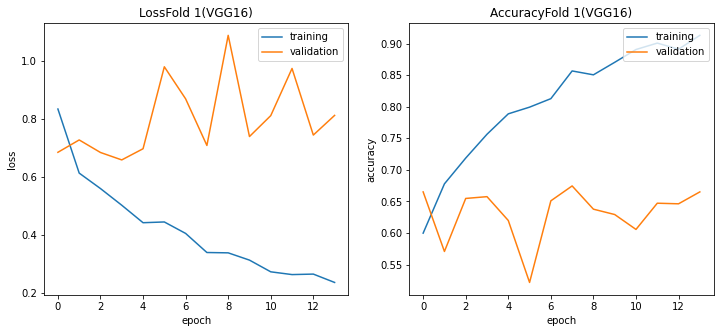

<Figure size 432x288 with 0 Axes>

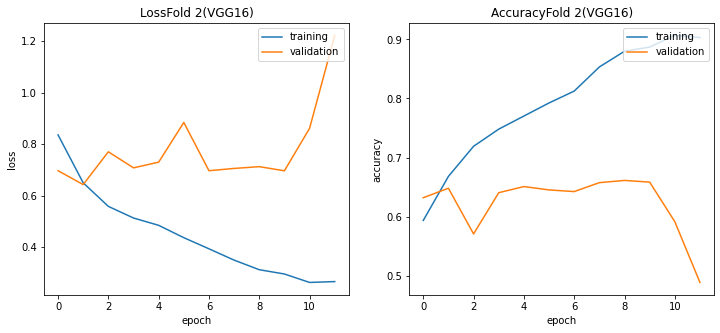

<Figure size 432x288 with 0 Axes>

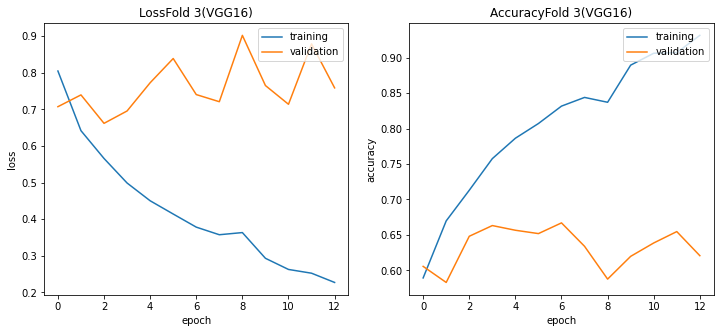

<Figure size 432x288 with 0 Axes>

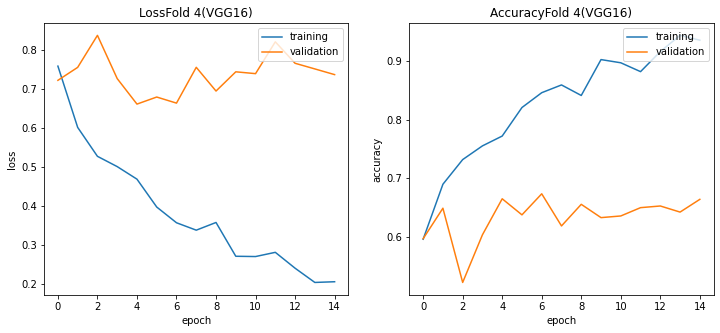

<Figure size 432x288 with 0 Axes>

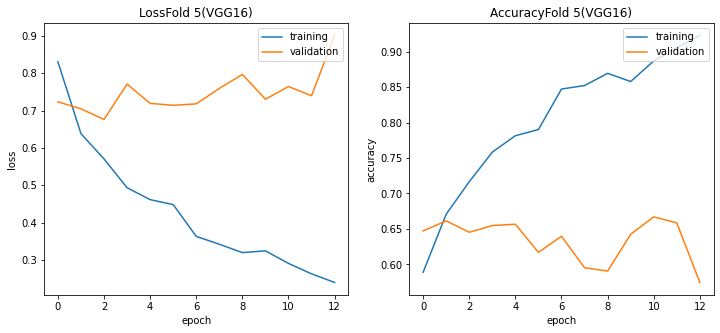

<Figure size 432x288 with 0 Axes>

In [ ]:
# ploting folds accuracy and loss curves
for i, histo in enumerate(histories):
 plot_histories(histo, "Fold "+str(i+1)+"("+ base +")")
 plt.savefig('/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/' + base + '/plt_fold'+str(i+1))

##### Metric of model

In [ ]:
print(base, "Metrique after training-------------------")
print(model_deep_metric(base))
print(name, "Metrique after training-------------------")
print(model_tabular_metric(name))

VGG16 Metrique after training-------------------
([0.6745283018867925, 0.6613207547169812, 0.6669811320754717, 0.6735849056603773, 0.6669811320754717], [0.7001338688085676, 0.6882430647291942, 0.6682080924855491, 0.7052341597796143, 0.6811414392059554], [0.812111801242236, 0.8090062111801242, 0.8975155279503105, 0.7950310559006211, 0.8511627906976744], [0.7519769949676491, 0.7437544610992147, 0.7660702451954937, 0.7474452554744526, 0.7567195037904892], [0.6567761995800027, 0.641151235334894, 0.6648732770120053, 0.6550122894706456, 0.6515943416502219])
KNN Metrique after training-------------------
([0.7415094339622641, 0.7443396226415094, 0.7292452830188679, 0.7028301886792453, 0.7245283018867924], [0.8627450980392157, 0.8348294434470377, 0.8275229357798165, 0.8063314711359404, 0.8286778398510242], [0.6832298136645962, 0.7220496894409938, 0.7003105590062112, 0.672360248447205, 0.689922480620155], [0.7625649913344887, 0.7743547044129891, 0.7586206896551725, 0.7332768839966131, 0.7529610

--------------------------------------------------------------------------------
### VGG19 Model
--------------------------------------------------------------------------------

In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)

name="SVC"
base= "VGG19"
save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/'    
folds_y = []
folds_y_pred = []
histories= []

# metric on tabular data for each fold
folds_yt= []
folds_y_predt = []
folds_y_pred_probat = []

fold = 0
for train, test in skf.split(X,Y_):
    fold+=1
    print("########################################################################")
    print(f"Fold #{fold}")
    print("########################################################################")
    x_train = X[train]
    y_train = Y[train]
    x_test = X[test]
    y_test = Y[test]

    x_train_tabular = X_tabular[train]
    y_train_tabular = Y_tabular[train]
    x_test_tabular = X_tabular[test]
    y_test_tabular = Y_tabular[test]
        
    with strategy.scope():
        model = create_model(base)
      
    checkpoint = ModelCheckpoint( save_dir + base +'/fold_'+str(fold)+'.h5', monitor='val_accuracy', save_best_only=True, verbose= 1, save_weights_only=False)
    history= model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epochs,batch_size = batch_size, callbacks=[reduce_lr,early_stopping, checkpoint])
    del model
    #loading best classifier and save it to my drive
    model= load_model(save_dir + base + '/fold_' + str(fold)+'.h5')
    pred = model.predict(x_test) 
    folds_y.append(y_test)
    folds_y_pred.append(pred)
    histories.append(history.history)

    # estimator on tabular data fiting and metric saving
    model_t= model_tabular(name).fit(x_train_tabular, y_train_tabular)
    pred_t= model_t.predict(x_test_tabular)
    pred_probt= model_t.predict_proba(x_test_tabular)
    folds_yt.append(y_test_tabular)
    folds_y_predt.append(pred_t)
    folds_y_pred_probat.append(pred_probt)

    del model, x_train, y_train, x_test, y_test, model_t, x_train_tabular, y_train_tabular, x_test_tabular, y_test_tabular

########################################################################
Fold #1
########################################################################
80134624/80134624 [==============================] - 3s 0us/step
Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 0.7890 - accuracy: 0.5969
Epoch 1: val_accuracy improved from -inf to 0.64245, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/VGG19/fold_1.h5
133/133 [==============================] - 50s 285ms/step - loss: 0.7890 - accuracy: 0.5969 - val_loss: 0.6754 - val_accuracy: 0.6425 - lr: 0.0010
Epoch 2/50
133/133 [==============================] - ETA: 0s - loss: 0.6252 - accuracy: 0.6658
Epoch 2: val_accuracy did not improve from 0.64245
133/133 [==============================] - 31s 230ms/step - loss: 0.6252 - accuracy: 0.6658 - val_loss: 0.6692 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 3/50
133/133 [==============================] - ETA: 0s - loss: 0.5830 - accuracy: 0.6995
Epoch

##### Save necessary element to calculate metrics

In [ ]:
save_fold_vectors_deep(histories, folds_y, folds_y_pred, base)
save_fold_vectors_tabular(folds_yt, folds_y_predt, folds_y_pred_probat, name)

##### Plotting the story

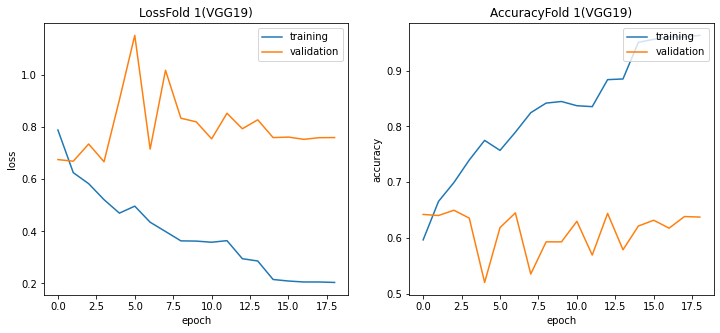

<Figure size 432x288 with 0 Axes>

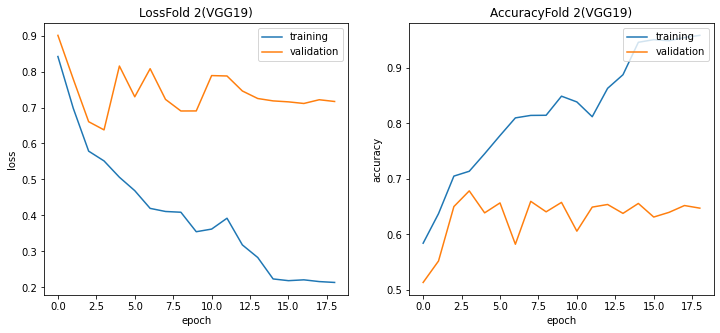

<Figure size 432x288 with 0 Axes>

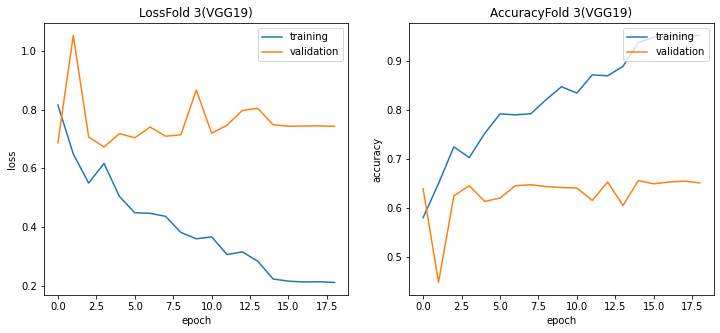

<Figure size 432x288 with 0 Axes>

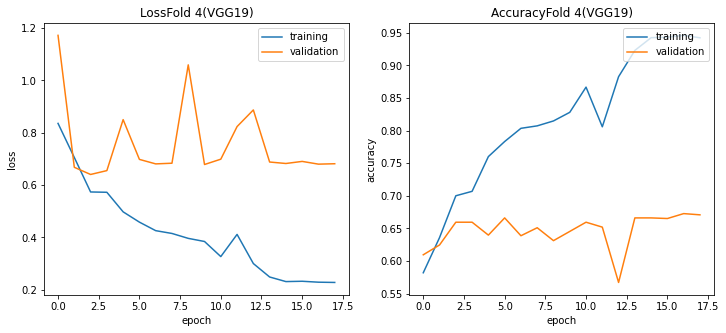

<Figure size 432x288 with 0 Axes>

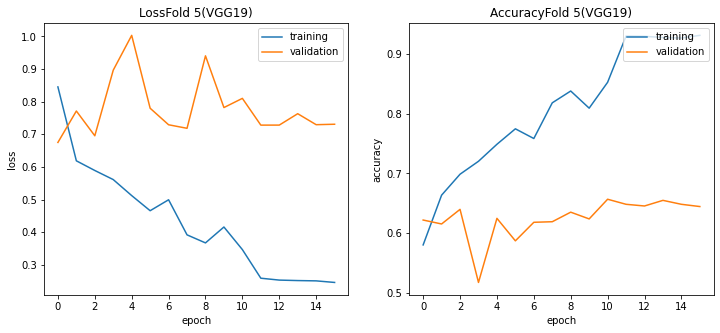

<Figure size 432x288 with 0 Axes>

In [ ]:
# ploting folds accuracy and loss curves
for i, histo in enumerate(histories):
 plot_histories(histo, "Fold "+str(i+1)+"("+ base +")")
 plt.savefig('/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/' + base + '/plt_fold'+str(i+1))

##### Metric of model

In [ ]:
name="SVC"
base= "VGG19"
print(base, "Metrique after training-------------------")
print(model_deep_metric(base))
print(name, "Metrique after training-------------------")
print(model_tabular_metric(name))

VGG19 Metrique after training-------------------
([0.65, 0.6783018867924528, 0.6556603773584906, 0.6726415094339623, 0.6566037735849056], [0.6441393875395988, 0.686806411837238, 0.6887686062246279, 0.7187039764359352, 0.6631823461091754], [0.9472049689440993, 0.8649068322981367, 0.7903726708074534, 0.7577639751552795, 0.8852713178294573], [0.7668133249528599, 0.7656357388316152, 0.7360809833694866, 0.7377173091458805, 0.7583001328021248], [0.6716272158936931, 0.668704410737896, 0.6341039292805383, 0.6546275787691488, 0.6456615248133817])
SVC Metrique after training-------------------
([0.719811320754717, 0.7377358490566037, 0.7367924528301887, 0.7094339622641509, 0.7367924528301887], [0.9727520435967303, 0.9399038461538461, 0.9138321995464853, 0.8668122270742358, 0.9399038461538461], [0.5543478260869565, 0.6071428571428571, 0.6257763975155279, 0.6164596273291926, 0.6062015503875969], [0.7062314540059348, 0.7377358490566038, 0.7428571428571429, 0.7205081669691471, 0.7370405278039586], [

--------------------------------------------------------------------------------
### Xception Model
--------------------------------------------------------------------------------

In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)

name="DecisionTree"
base= "Xception"
save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/' 
folds_y = []
folds_y_pred = []
histories= []

# metric on tabular data for each fold
folds_yt= []
folds_y_predt = []
folds_y_pred_probat = []

fold = 0
for train, test in skf.split(X,Y_):
    fold+=1
    print("########################################################################")
    print(f"Fold #{fold}")
    print("########################################################################")
    x_train = X[train]
    y_train = Y[train]
    x_test = X[test]
    y_test = Y[test]

    x_train_tabular = X_tabular[train]
    y_train_tabular = Y_tabular[train]
    x_test_tabular = X_tabular[test]
    y_test_tabular = Y_tabular[test]
        
    with strategy.scope():
        model = create_model(base)
      
    checkpoint = ModelCheckpoint( save_dir + base +'/fold_'+str(fold)+'.h5', monitor='val_accuracy', save_best_only=True, verbose= 1, save_weights_only=False)
    history= model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epochs,batch_size = batch_size, callbacks=[reduce_lr,early_stopping, checkpoint])
    del model
    #loading best classifier and save it to my drive
    model= load_model(save_dir + base + '/fold_' + str(fold)+'.h5')
    pred = model.predict(x_test) 
    folds_y.append(y_test)
    folds_y_pred.append(pred)
    histories.append(history.history)

    # estimator on tabular data fiting and metric saving
    model_t= model_tabular(name).fit(x_train_tabular, y_train_tabular)
    pred_t= model_t.predict(x_test_tabular)
    pred_probt= model_t.predict_proba(x_test_tabular)
    folds_yt.append(y_test_tabular)
    folds_y_predt.append(pred_t)
    folds_y_pred_probat.append(pred_probt) 

    del model, x_train, y_train, x_test, y_test, model_t, x_train_tabular, y_train_tabular, x_test_tabular, y_test_tabular

########################################################################
Fold #1
########################################################################
Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 2.3627 - accuracy: 0.5653
Epoch 1: val_accuracy improved from -inf to 0.52264, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/Xception/fold_1.h5
133/133 [==============================] - 28s 173ms/step - loss: 2.3627 - accuracy: 0.5653 - val_loss: 3.0538 - val_accuracy: 0.5226 - lr: 0.0010
Epoch 2/50
133/133 [==============================] - ETA: 0s - loss: 1.8450 - accuracy: 0.6401
Epoch 2: val_accuracy improved from 0.52264 to 0.53962, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/Xception/fold_1.h5
133/133 [==============================] - 21s 161ms/step - loss: 1.8450 - accuracy: 0.6401 - val_loss: 2.4538 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 3/50
133/133 [==============================] - ETA: 0s - l

##### Save necessary element to calculate metrics

In [ ]:
save_fold_vectors_deep(histories, folds_y, folds_y_pred, base)
save_fold_vectors_tabular(folds_yt, folds_y_predt, folds_y_pred_probat, name)

##### Plotting the story

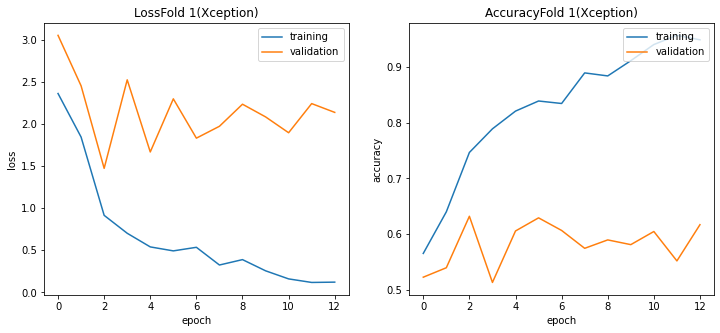

<Figure size 432x288 with 0 Axes>

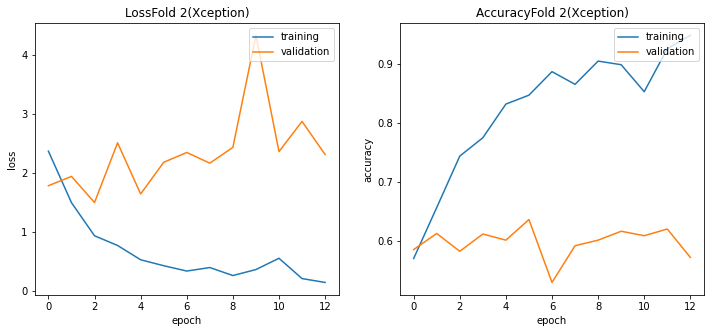

<Figure size 432x288 with 0 Axes>

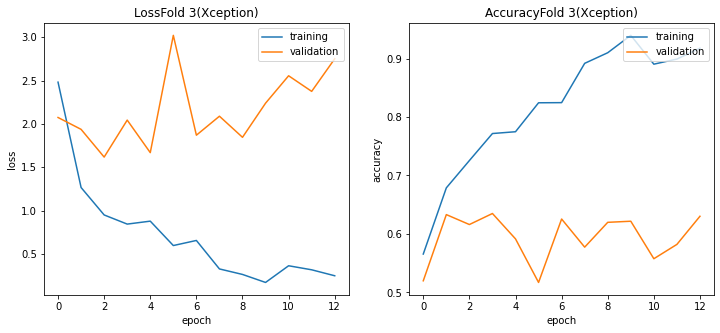

<Figure size 432x288 with 0 Axes>

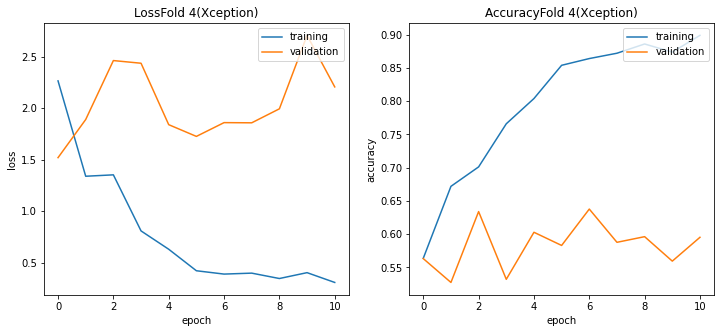

<Figure size 432x288 with 0 Axes>

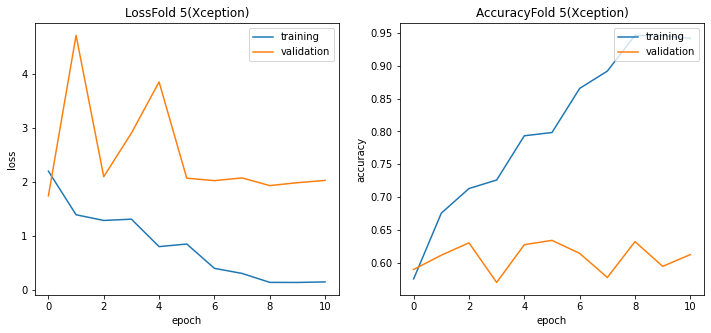

<Figure size 432x288 with 0 Axes>

In [ ]:
# ploting folds accuracy and loss curves
for i, histo in enumerate(histories):
 plot_histories(histo, "Fold "+str(i+1)+"("+ base +")")
 plt.savefig('/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/' + base + '/plt_fold'+str(i+1))

##### Metric of model

In [ ]:
print(base, "Metrique after training-------------------")
print(model_deep_metric(base))
print(name, "Metrique after training-------------------")
print(model_tabular_metric(name))

Xception Metrique after training-------------------
([0.6320754716981132, 0.6358490566037736, 0.6349056603773585, 0.6377358490566037, 0.6339622641509434], [0.6657963446475196, 0.6411378555798687, 0.6557575757575758, 0.6540284360189573, 0.6653796653796654], [0.7919254658385093, 0.9099378881987578, 0.8400621118012422, 0.8571428571428571, 0.8015503875968992], [0.7234042553191491, 0.7522464698331193, 0.7365554799183118, 0.7419354838709676, 0.7271448663853728], [0.6050070158611747, 0.6219387908036329, 0.6087298517085751, 0.6140512550465157, 0.6065414227958398])
DecisionTree Metrique after training-------------------
([0.7481132075471698, 0.7490566037735849, 0.7367924528301887, 0.6971698113207547, 0.7509433962264151], [0.8178752107925801, 0.8098360655737705, 0.819614711033275, 0.7741935483870968, 0.8169717138103162], [0.7531055900621118, 0.7670807453416149, 0.7267080745341615, 0.7080745341614907, 0.7612403100775194], [0.7841552142279709, 0.7878787878787878, 0.7703703703703704, 0.739659367396

--------------------------------------------------------------------------------
### InceptionV3 Model
--------------------------------------------------------------------------------

In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)

name="RandomForest"
base= "InceptionV3"
save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/'  
folds_y = []
folds_y_pred = []
histories= []

# metric on tabular data for each fold
folds_yt= []
folds_y_predt = []
folds_y_pred_probat = []

fold = 0
for train, test in skf.split(X,Y_):
    fold+=1
    print("########################################################################")
    print(f"Fold #{fold}")
    print("########################################################################")
    x_train = X[train]
    y_train = Y[train]
    x_test = X[test]
    y_test = Y[test]

    x_train_tabular = X_tabular[train]
    y_train_tabular = Y_tabular[train]
    x_test_tabular = X_tabular[test]
    y_test_tabular = Y_tabular[test]
        
    with strategy.scope():
        model = create_model(base)
      
    checkpoint = ModelCheckpoint( save_dir + base +'/fold_'+str(fold)+'.h5', monitor='val_accuracy', save_best_only=True, verbose= 1, save_weights_only=False)
    history= model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epochs,batch_size = batch_size, callbacks=[reduce_lr,early_stopping, checkpoint])
    del model
    #loading best classifier and save it to my drive
    model= load_model(save_dir + base + '/fold_' + str(fold)+'.h5')
    pred = model.predict(x_test) 
    folds_y.append(y_test)
    folds_y_pred.append(pred)
    histories.append(history.history)

    # estimator on tabular data fiting and metric saving
    model_t= model_tabular(name).fit(x_train_tabular, y_train_tabular)
    pred_t= model_t.predict(x_test_tabular)
    pred_probt= model_t.predict_proba(x_test_tabular)
    folds_yt.append(y_test_tabular)
    folds_y_predt.append(pred_t)
    folds_y_pred_probat.append(pred_probt)

    del model, x_train, y_train, x_test, y_test, model_t, x_train_tabular, y_train_tabular, x_test_tabular, y_test_tabular

########################################################################
Fold #1
########################################################################
Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 4.6507 - accuracy: 0.5658
Epoch 1: val_accuracy improved from -inf to 0.60472, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/InceptionV3/fold_1.h5
133/133 [==============================] - 26s 126ms/step - loss: 4.6507 - accuracy: 0.5658 - val_loss: 1.6817 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 2/50
132/133 [============================>.] - ETA: 0s - loss: 1.8810 - accuracy: 0.6364
Epoch 2: val_accuracy did not improve from 0.60472
133/133 [==============================] - 11s 83ms/step - loss: 1.8778 - accuracy: 0.6366 - val_loss: 1.8147 - val_accuracy: 0.5679 - lr: 0.0010
Epoch 3/50
132/133 [============================>.] - ETA: 0s - loss: 0.9469 - accuracy: 0.7351
Epoch 3: val_accuracy did not improve from 0.60472
133/133 [=====

##### Save necessary element to calculate metrics

In [ ]:
save_fold_vectors_deep(histories, folds_y, folds_y_pred, base)
save_fold_vectors_tabular(folds_yt, folds_y_predt, folds_y_pred_probat, name)

##### Plotting the story

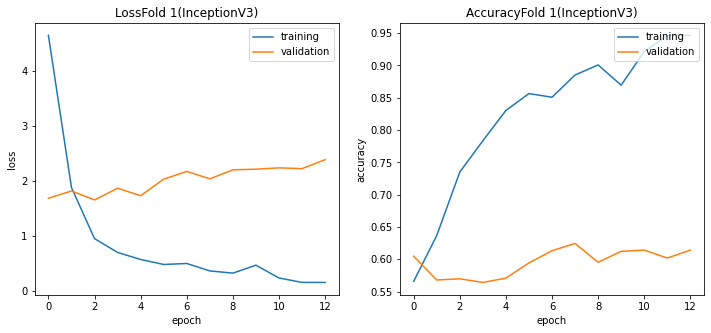

<Figure size 432x288 with 0 Axes>

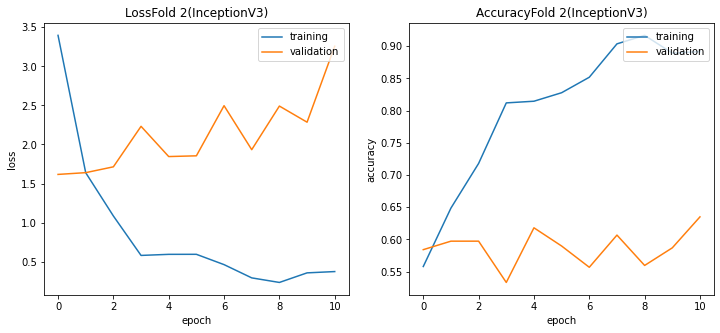

<Figure size 432x288 with 0 Axes>

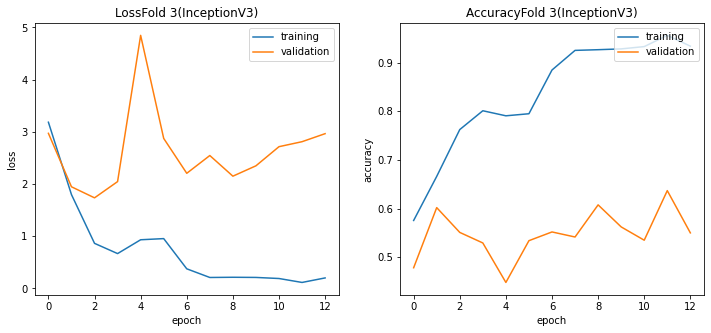

<Figure size 432x288 with 0 Axes>

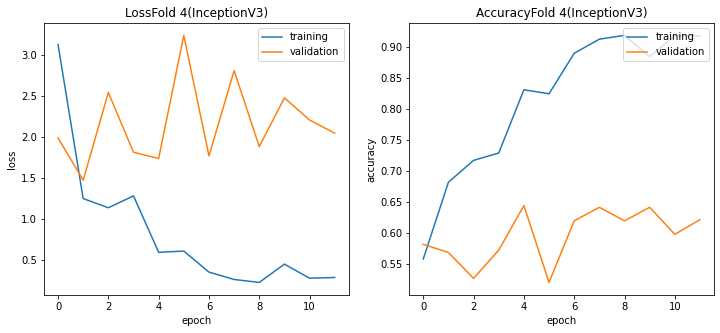

<Figure size 432x288 with 0 Axes>

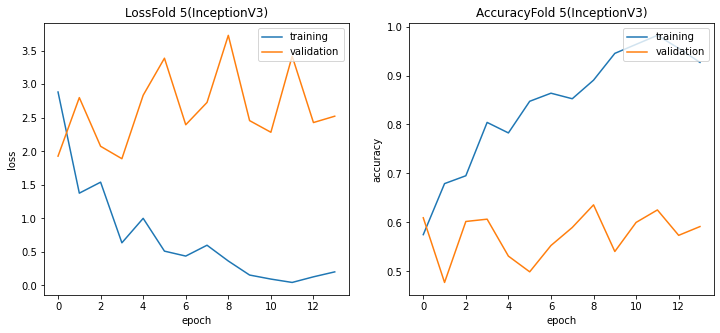

<Figure size 432x288 with 0 Axes>

In [ ]:
# ploting folds accuracy and loss curves
for i, histo in enumerate(histories):
 plot_histories(histo, "Fold "+str(i+1)+"("+ base +")")
 plt.savefig('/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/' + base + '/plt_fold'+str(i+1))

##### Metric of model

In [ ]:
print(base, "Metrique after training-------------------")
print(model_deep_metric(base))
print(name, "Metrique after training-------------------")
print(model_tabular_metric(name))

InceptionV3 Metrique after training-------------------
([0.6245283018867924, 0.6349056603773585, 0.6367924528301887, 0.6443396226415095, 0.6358490566037736], [0.6560913705583756, 0.6423034330011074, 0.6500579374275782, 0.6931982633863966, 0.6373276776246023], [0.8027950310559007, 0.9006211180124224, 0.8711180124223602, 0.7437888198757764, 0.931782945736434], [0.7220670391061452, 0.7498383968972204, 0.7445255474452553, 0.7176029962546816, 0.756926952141058], [0.5945898029262466, 0.6173300604495983, 0.6143690702366317, 0.6230218959208406, 0.6306296507781132])
RandomForest Metrique after training-------------------
([0.7537735849056604, 0.7490566037735849, 0.7433962264150943, 0.7094339622641509, 0.7509433962264151], [0.8401420959147424, 0.8203389830508474, 0.8206896551724138, 0.7857142857142857, 0.8359788359788359], [0.734472049689441, 0.7515527950310559, 0.7391304347826086, 0.717391304347826, 0.7348837209302326], [0.7837613918806959, 0.7844408427876822, 0.7777777777777778, 0.75, 0.782178

--------------------------------------------------------------------------------
### MobileNet Model
--------------------------------------------------------------------------------

In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)

name="MLP"
base= "MobileNet"
save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/'  
folds_y = []
folds_y_pred = []
histories= []

# metric on tabular data for each fold
folds_yt= []
folds_y_predt = []
folds_y_pred_probat = []

fold = 0
for train, test in skf.split(X,Y_):
    fold+=1
    print("########################################################################")
    print(f"Fold #{fold}")
    print("########################################################################")
    x_train = X[train]
    y_train = Y[train]
    x_test = X[test]
    y_test = Y[test]

    x_train_tabular = X_tabular[train]
    y_train_tabular = Y_tabular[train]
    x_test_tabular = X_tabular[test]
    y_test_tabular = Y_tabular[test]
        
    with strategy.scope():
        model = create_model(base)
      
    checkpoint = ModelCheckpoint( save_dir + base +'/fold_'+str(fold)+'.h5', monitor='val_accuracy', save_best_only=True, verbose= 1, save_weights_only=False)
    history= model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epochs,batch_size = batch_size, callbacks=[reduce_lr,early_stopping, checkpoint])
    del model
    #loading best classifier and save it to my drive
    model= load_model(save_dir + base + '/fold_' + str(fold)+'.h5')
    pred = model.predict(x_test) 
    folds_y.append(y_test)
    folds_y_pred.append(pred)
    histories.append(history.history)

    # estimator on tabular data fiting and metric saving
    model_t= model_tabular(name).fit(x_train_tabular, y_train_tabular)
    pred_t= model_t.predict(x_test_tabular)
    pred_probt= model_t.predict_proba(x_test_tabular)
    folds_yt.append(y_test_tabular)
    folds_y_predt.append(pred_t)
    folds_y_pred_probat.append(pred_probt)

    del model, x_train, y_train, x_test, y_test,  model_t, x_train_tabular, y_train_tabular, x_test_tabular, y_test_tabular

########################################################################
Fold #1
########################################################################
Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 3.5201 - accuracy: 0.5776
Epoch 1: val_accuracy improved from -inf to 0.61321, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/MobileNet/fold_1.h5
133/133 [==============================] - 15s 68ms/step - loss: 3.5201 - accuracy: 0.5776 - val_loss: 2.7405 - val_accuracy: 0.6132 - lr: 0.0010
Epoch 2/50
131/133 [============================>.] - ETA: 0s - loss: 1.5437 - accuracy: 0.7464
Epoch 2: val_accuracy did not improve from 0.61321
133/133 [==============================] - 6s 42ms/step - loss: 1.5488 - accuracy: 0.7453 - val_loss: 2.5430 - val_accuracy: 0.6123 - lr: 0.0010
Epoch 3/50
133/133 [==============================] - ETA: 0s - loss: 0.8173 - accuracy: 0.8396
Epoch 3: val_accuracy did not improve from 0.61321
133/133 [=========

##### Save necessary element to calculate metrics

In [ ]:
save_fold_vectors_deep(histories, folds_y, folds_y_pred, base)
save_fold_vectors_tabular(folds_yt, folds_y_predt, folds_y_pred_probat, name)

##### Plotting the story

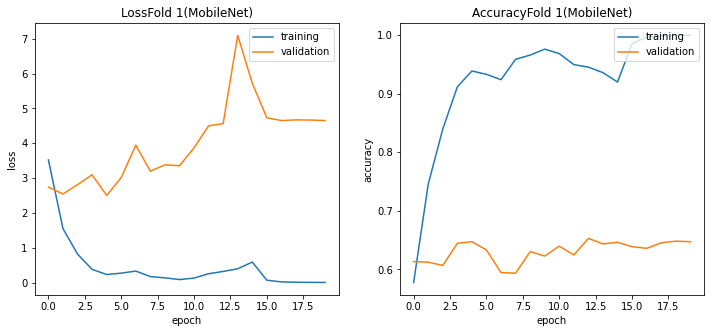

<Figure size 432x288 with 0 Axes>

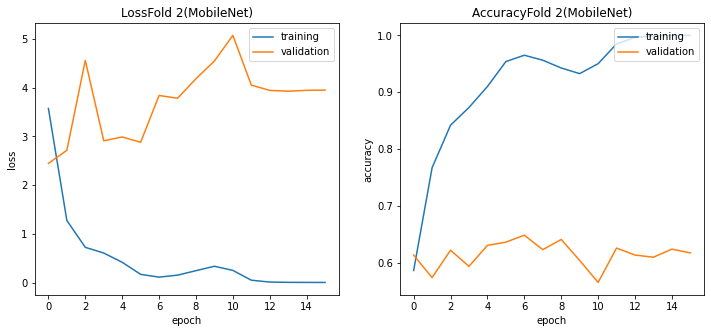

<Figure size 432x288 with 0 Axes>

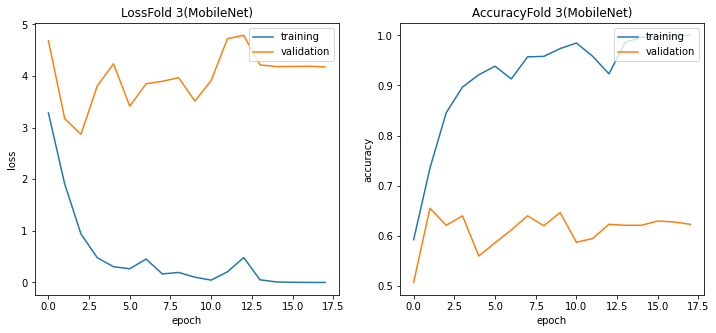

<Figure size 432x288 with 0 Axes>

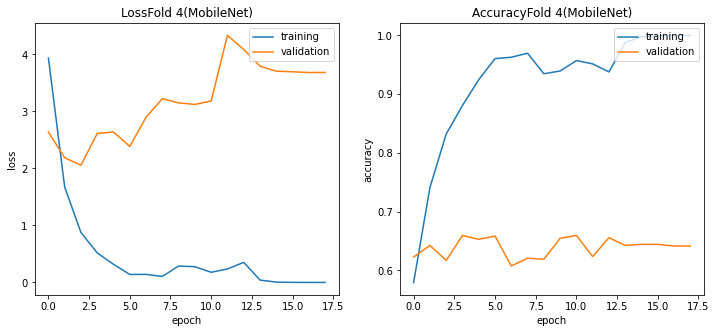

<Figure size 432x288 with 0 Axes>

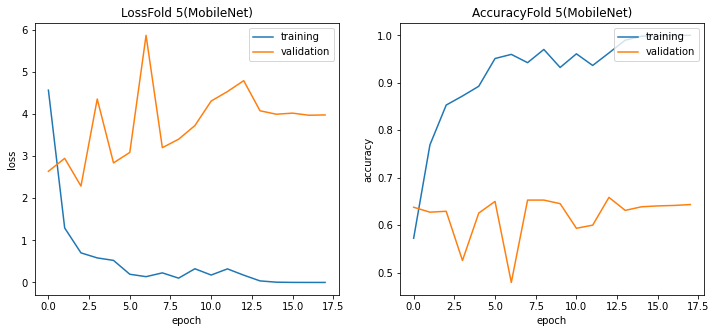

<Figure size 432x288 with 0 Axes>

In [ ]:
# ploting folds accuracy and loss curves
for i, histo in enumerate(histories):
 plot_histories(histo, "Fold "+str(i+1)+"("+ base +")")
 plt.savefig('/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/' + base + '/plt_fold'+str(i+1))

##### Metric of model

In [ ]:
print(base, "Metrique after training-------------------")
print(model_deep_metric(base))
print(name, "Metrique after training-------------------")
print(model_tabular_metric(name))

MobileNet Metrique after training-------------------
([0.6528301886792452, 0.6490566037735849, 0.6547169811320754, 0.659433962264151, 0.6584905660377358], [0.6927374301675978, 0.6541950113378685, 0.6568848758465011, 0.6830530401034929, 0.6766541822721598], [0.7701863354037267, 0.8959627329192547, 0.9037267080745341, 0.8198757763975155, 0.8403100775193798], [0.7294117647058824, 0.7562254259501967, 0.7607843137254903, 0.7452364149611855, 0.7496542185338866], [0.6312524360140315, 0.6388952584779231, 0.6502815183830206, 0.6394359277172517, 0.6394853922943811])
MLP Metrique after training-------------------
([0.7566037735849057, 0.7518867924528302, 0.730188679245283, 0.7037735849056603, 0.7462264150943396], [0.876953125, 0.8359788359788359, 0.8638211382113821, 0.8466386554621849, 0.8715415019762845], [0.6972049689440993, 0.7360248447204969, 0.6599378881987578, 0.6257763975155279, 0.6837209302325581], [0.7768166089965398, 0.7828241123038809, 0.7482394366197183, 0.7196428571428571, 0.76629018

--------------------------------------------------------------------------------
### ResNet50 Model
--------------------------------------------------------------------------------

In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)

base= "ResNet50"
save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/'  
folds_y = []
folds_y_pred = []
histories= []

# metric on tabular data for each fold
folds_yt= []
folds_y_predt = []
folds_y_pred_probat = []

fold = 0
for train, test in skf.split(X,Y_):
    fold+=1
    print("########################################################################")
    print(f"Fold #{fold}")
    print("########################################################################")
    x_train = X[train]
    y_train = Y[train]
    x_test = X[test]
    y_test = Y[test]

    x_train_tabular = X_tabular[train]
    y_train_tabular = Y_tabular[train]
    x_test_tabular = X_tabular[test]
    y_test_tabular = Y_tabular[test]
        
    with strategy.scope():
        model = create_model(base)
      
    checkpoint = ModelCheckpoint( save_dir + base +'/fold_'+str(fold)+'.h5', monitor='val_accuracy', save_best_only=True, verbose= 1, save_weights_only=False)
    history= model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epochs,batch_size = batch_size, callbacks=[reduce_lr,early_stopping, checkpoint])
    del model
    #loading best classifier and save it to my drive
    model= load_model(save_dir + base + '/fold_' + str(fold)+'.h5')
    pred = model.predict(x_test) 
    folds_y.append(y_test)
    folds_y_pred.append(pred)
    histories.append(history.history)

    del model, x_train, y_train, x_test, y_test

########################################################################
Fold #1
########################################################################
Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 3.7873 - accuracy: 0.5830
Epoch 1: val_accuracy improved from -inf to 0.61887, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/ResNet50/fold_1.h5
133/133 [==============================] - 14s 67ms/step - loss: 3.7873 - accuracy: 0.5830 - val_loss: 2.4022 - val_accuracy: 0.6189 - lr: 0.0010
Epoch 2/50
133/133 [==============================] - ETA: 0s - loss: 1.4028 - accuracy: 0.7467
Epoch 2: val_accuracy improved from 0.61887 to 0.62547, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/ResNet50/fold_1.h5
133/133 [==============================] - 6s 44ms/step - loss: 1.4028 - accuracy: 0.7467 - val_loss: 2.6602 - val_accuracy: 0.6255 - lr: 0.0010
Epoch 3/50
131/133 [============================>.] - ETA: 0s - loss

##### Save necessary element to calculate metrics

In [ ]:
save_fold_vectors_deep(histories, folds_y, folds_y_pred, base)

##### Plotting the story

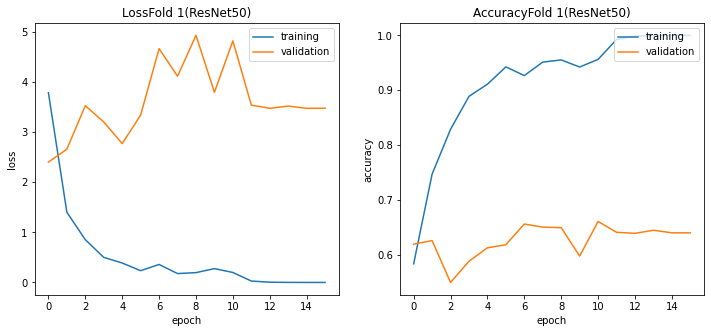

<Figure size 432x288 with 0 Axes>

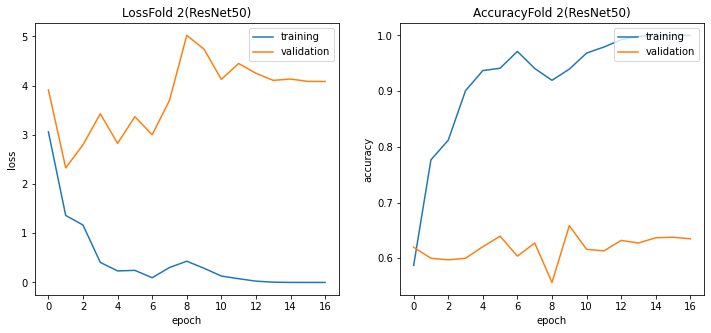

<Figure size 432x288 with 0 Axes>

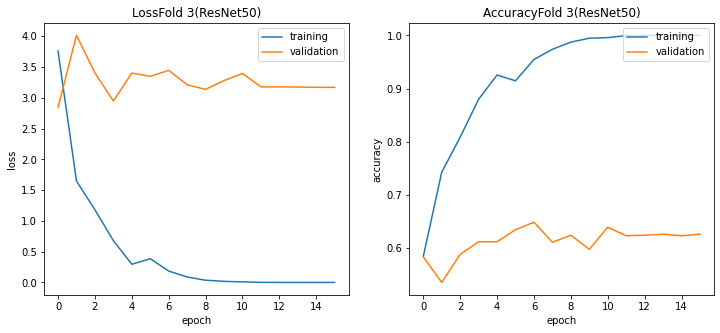

<Figure size 432x288 with 0 Axes>

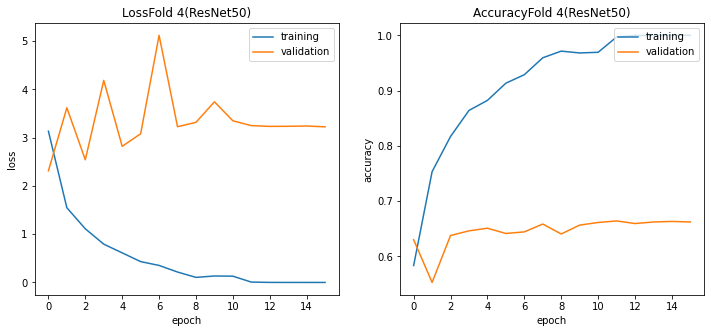

<Figure size 432x288 with 0 Axes>

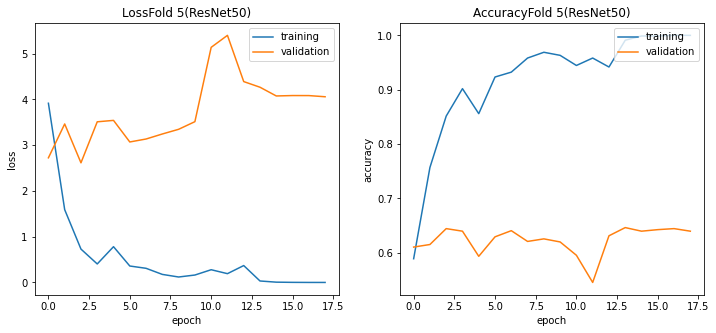

<Figure size 432x288 with 0 Axes>

In [ ]:
# ploting folds accuracy and loss curves
for i, histo in enumerate(histories):
 plot_histories(histo,"Fold "+str(i+1)+"("+ base +")")
 plt.savefig('/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/' + base + '/plt_fold'+str(i+1))

##### Metric of model

In [ ]:
print(base, "Metrique after training-------------------")
print(model_deep_metric(base))

ResNet50 Metrique after training-------------------
([0.660377358490566, 0.6584905660377358, 0.6490566037735849, 0.6641509433962264, 0.6462264150943396], [0.6606334841628959, 0.6745049504950495, 0.6748071979434447, 0.7208588957055214, 0.6814516129032258], [0.906832298136646, 0.8462732919254659, 0.8152173913043478, 0.7298136645962733, 0.786046511627907], [0.7643979057591623, 0.7506887052341598, 0.7383966244725739, 0.7253086419753086, 0.7300215982721382], [0.6598621966269025, 0.6408239038189534, 0.6264106911703039, 0.6471941537351137, 0.6223713760718661])


--------------------------------------------------------------------------------
### DenseNet201 Model
--------------------------------------------------------------------------------

In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)

base= "DenseNet201"
save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/'   
folds_y = []
folds_y_pred = []
histories= []

# metric on tabular data for each fold
folds_yt= []
folds_y_predt = []
folds_y_pred_probat = []

fold = 0
for train, test in skf.split(X,Y_):
    fold+=1
    print("########################################################################")
    print(f"Fold #{fold}")
    print("########################################################################")
    x_train = X[train]
    y_train = Y[train]
    x_test = X[test]
    y_test = Y[test]

    x_train_tabular = X_tabular[train]
    y_train_tabular = Y_tabular[train]
    x_test_tabular = X_tabular[test]
    y_test_tabular = Y_tabular[test]
        
    with strategy.scope():
        model = create_model(base)
      
    checkpoint = ModelCheckpoint( save_dir + base +'/fold_'+str(fold)+'.h5', monitor='val_accuracy', save_best_only=True, verbose= 1, save_weights_only=False)
    history= model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epochs,batch_size = batch_size, callbacks=[reduce_lr,early_stopping, checkpoint])
    del model
    #loading best classifier and save it to my drive
    model= load_model(save_dir + base + '/fold_' + str(fold)+'.h5')
    pred = model.predict(x_test) 
    folds_y.append(y_test)
    folds_y_pred.append(pred)
    histories.append(history.history)

    del model, x_train, y_train, x_test, y_test

########################################################################
Fold #1
########################################################################
74836368/74836368 [==============================] - 4s 0us/step
Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 2.8518 - accuracy: 0.5936
Epoch 1: val_accuracy improved from -inf to 0.69906, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/DenseNet201/fold_1.h5
133/133 [==============================] - 59s 284ms/step - loss: 2.8518 - accuracy: 0.5936 - val_loss: 1.3843 - val_accuracy: 0.6991 - lr: 0.0010
Epoch 2/50
133/133 [==============================] - ETA: 0s - loss: 1.2624 - accuracy: 0.7413
Epoch 2: val_accuracy improved from 0.69906 to 0.74623, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/DenseNet201/fold_1.h5
133/133 [==============================] - 26s 199ms/step - loss: 1.2624 - accuracy: 0.7413 - val_loss: 1.2011 - val_accuracy: 0.7462 - lr: 0

##### Save necessary element to calculate metrics

In [ ]:
save_fold_vectors_deep(histories, folds_y, folds_y_pred, base)

##### Plotting the story

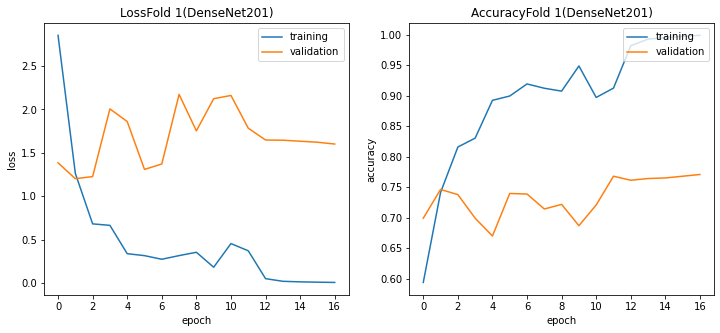

<Figure size 432x288 with 0 Axes>

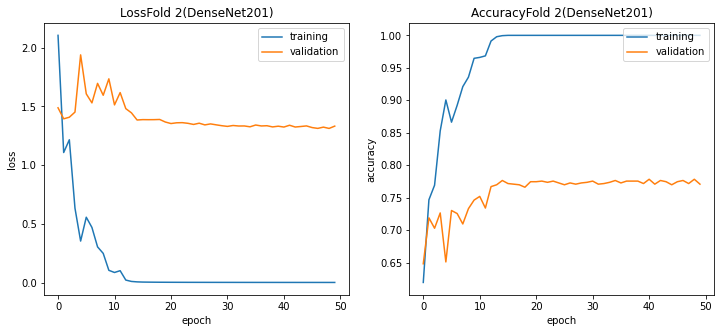

<Figure size 432x288 with 0 Axes>

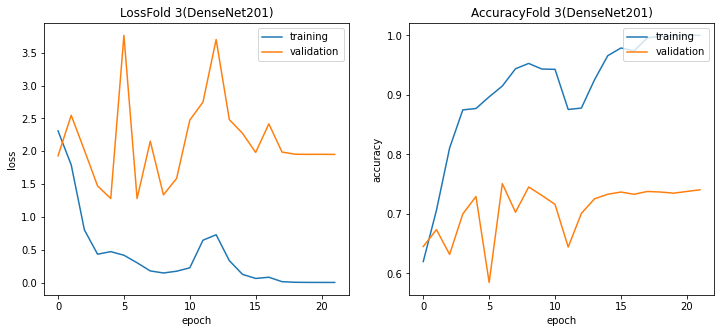

<Figure size 432x288 with 0 Axes>

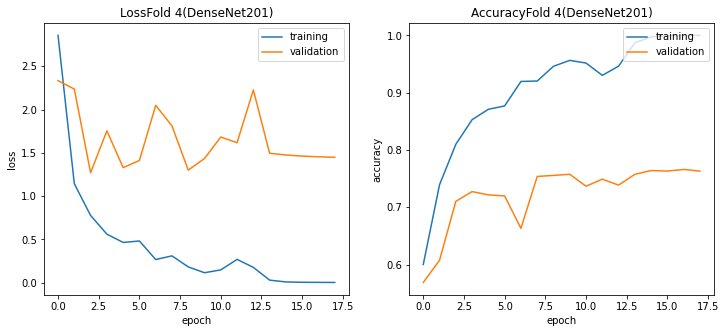

<Figure size 432x288 with 0 Axes>

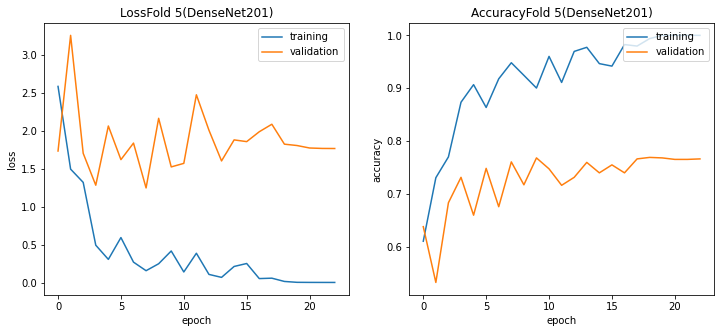

<Figure size 432x288 with 0 Axes>

In [ ]:
# ploting folds accuracy and loss curves
for i, histo in enumerate(histories):
 plot_histories(histo,"Fold "+str(i+1)+"("+ base +")")
 plt.savefig('/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/' + base + '/plt_fold'+str(i+1))

##### Metric of model

In [ ]:
print(base, "Metrique after training-------------------")
print(model_deep_metric(base))

DenseNet201 Metrique after training-------------------
([0.7707547169811321, 0.7783018867924528, 0.7509433962264151, 0.7660377358490567, 0.7688679245283019], [0.8118195956454122, 0.8020679468242246, 0.7802359882005899, 0.8123028391167192, 0.7923976608187134], [0.8105590062111802, 0.843167701863354, 0.8214285714285714, 0.7996894409937888, 0.8403100775193798], [0.8111888111888113, 0.822104466313399, 0.8003025718608169, 0.8059467918622848, 0.8156508653122648], [0.759626824201603, 0.7691801875113289, 0.7395944338908709, 0.7547429688541342, 0.7592307453029737])


--------------------------------------------------------------------------------
### InceptionResNetV2 Model
--------------------------------------------------------------------------------

In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)

base= "InceptionResNetV2"
save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/' 
folds_y = []
folds_y_pred = []
histories= []

# metric on tabular data for each fold
folds_yt= []
folds_y_predt = []
folds_y_pred_probat = []

fold = 0
for train, test in skf.split(X,Y_):
    fold+=1
    print("########################################################################")
    print(f"Fold #{fold}")
    print("########################################################################")
    x_train = X[train]
    y_train = Y[train]
    x_test = X[test]
    y_test = Y[test]

    x_train_tabular = X_tabular[train]
    y_train_tabular = Y_tabular[train]
    x_test_tabular = X_tabular[test]
    y_test_tabular = Y_tabular[test]
        
    with strategy.scope():
        model = create_model(base)
      
    checkpoint = ModelCheckpoint( save_dir + base +'/fold_'+str(fold)+'.h5', monitor='val_accuracy', save_best_only=True, verbose= 1, save_weights_only=False)
    history= model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epochs,batch_size = batch_size, callbacks=[reduce_lr,early_stopping, checkpoint])
    del model
    #loading best classifier and save it to my drive
    model= load_model(save_dir + base + '/fold_' + str(fold)+'.h5')
    pred = model.predict(x_test) 
    folds_y.append(y_test)
    folds_y_pred.append(pred)
    histories.append(history.history)

    del model, x_train, y_train, x_test, y_test

########################################################################
Fold #1
########################################################################
219055592/219055592 [==============================] - 10s 0us/step
Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 2.4603 - accuracy: 0.5778
Epoch 1: val_accuracy improved from -inf to 0.62358, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/InceptionResNetV2/fold_1.h5
133/133 [==============================] - 66s 343ms/step - loss: 2.4603 - accuracy: 0.5778 - val_loss: 3.1192 - val_accuracy: 0.6236 - lr: 0.0010
Epoch 2/50
133/133 [==============================] - ETA: 0s - loss: 2.2829 - accuracy: 0.6406
Epoch 2: val_accuracy improved from 0.62358 to 0.62453, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/InceptionResNetV2/fold_1.h5
133/133 [==============================] - 35s 261ms/step - loss: 2.2829 - accuracy: 0.6406 - val_loss: 1.6188 - val_accuracy:

##### Save necessary element to calculate metrics

In [ ]:
save_fold_vectors_deep(histories, folds_y, folds_y_pred, base)

##### Plotting the story

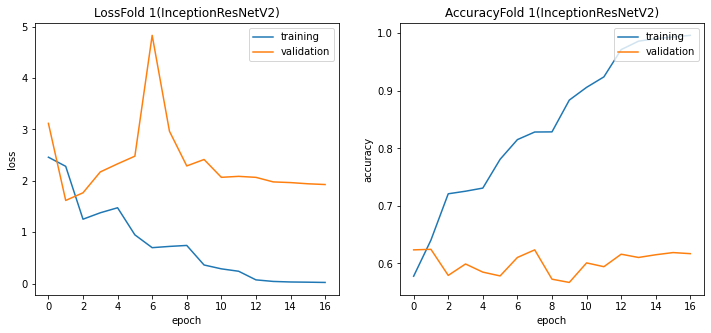

<Figure size 432x288 with 0 Axes>

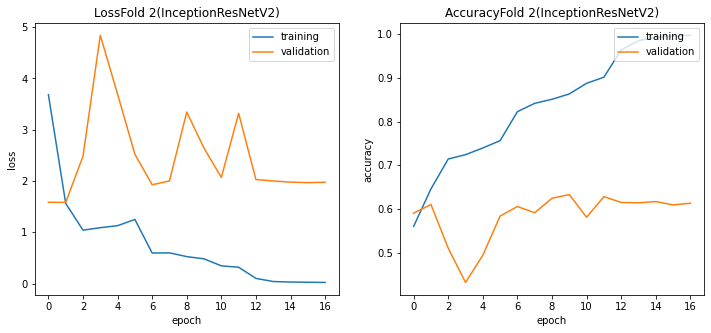

<Figure size 432x288 with 0 Axes>

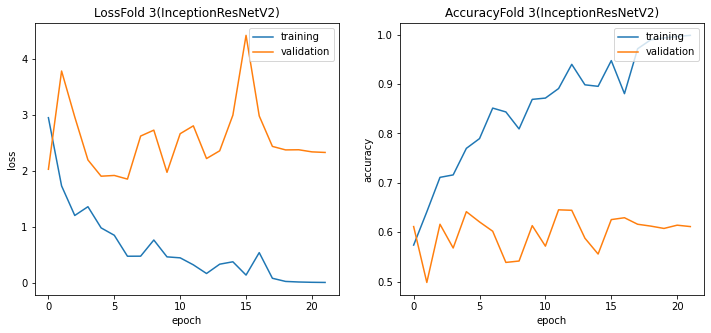

<Figure size 432x288 with 0 Axes>

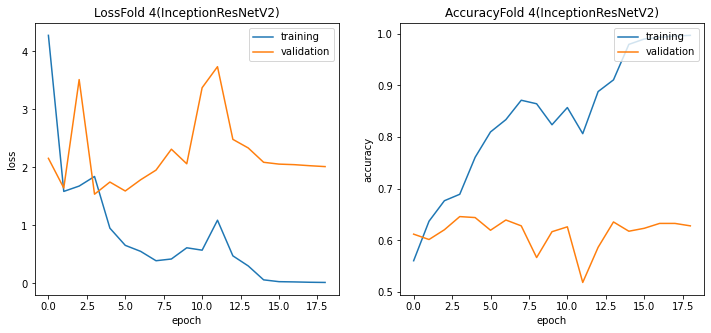

<Figure size 432x288 with 0 Axes>

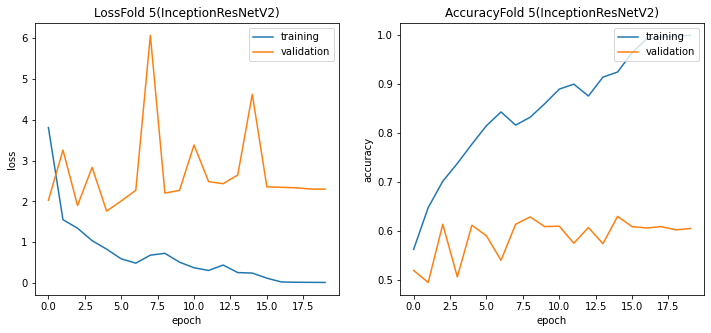

<Figure size 432x288 with 0 Axes>

In [ ]:
# ploting folds accuracy and loss curves
for i, histo in enumerate(histories):
 plot_histories(histo, "Fold "+str(i+1)+"("+ base +")")
 plt.savefig('/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/' + base + '/plt_fold'+str(i+1))

##### Metric of model

In [ ]:
print(base, "Metrique after training-------------------")
print(model_deep_metric(base))

InceptionResNetV2 Metrique after training-------------------
([0.6245283018867924, 0.6330188679245283, 0.6452830188679245, 0.6462264150943396, 0.629245283018868], [0.6522277227722773, 0.6440677966101694, 0.6495535714285714, 0.706605222734255, 0.6267605633802817], [0.8183229813664596, 0.8850931677018633, 0.9037267080745341, 0.7142857142857143, 0.9658914728682171], [0.7258953168044077, 0.7455853499018966, 0.7558441558441559, 0.7104247104247104, 0.7602196461256865], [0.5939710042432814, 0.6106053268765134, 0.6357523954703833, 0.628363736061504, 0.6467136150234742])


--------------------------------------------------------------------------------
### NasNetMobile Model
--------------------------------------------------------------------------------

In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)

base= "NASNetMobile"
save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/'   
folds_y = []
folds_y_pred = []
histories= []

# metric on tabular data for each fold
folds_yt= []
folds_y_predt = []
folds_y_pred_probat = []

fold = 0
for train, test in skf.split(X,Y_):
    fold+=1
    print("########################################################################")
    print(f"Fold #{fold}")
    print("########################################################################")
    x_train = X[train]
    y_train = Y[train]
    x_test = X[test]
    y_test = Y[test]

    x_train_tabular = X_tabular[train]
    y_train_tabular = Y_tabular[train]
    x_test_tabular = X_tabular[test]
    y_test_tabular = Y_tabular[test]
        
    with strategy.scope():
        model = create_model(base)
      
    checkpoint = ModelCheckpoint( save_dir + base +'/fold_'+str(fold)+'.h5', monitor='val_accuracy', save_best_only=True, verbose= 1, save_weights_only=False)
    history= model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epochs,batch_size = batch_size, callbacks=[reduce_lr,early_stopping, checkpoint])
    del model
    #loading best classifier and save it to my drive
    model= load_model(save_dir + base + '/fold_' + str(fold)+'.h5')
    pred = model.predict(x_test) 
    folds_y.append(y_test)
    folds_y_pred.append(pred)
    histories.append(history.history)

    del model, x_train, y_train, x_test, y_test

########################################################################
Fold #1
########################################################################
Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 2.6504 - accuracy: 0.5797
Epoch 1: val_accuracy improved from -inf to 0.65566, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/NASNetMobile/fold_1.h5
133/133 [==============================] - 38s 160ms/step - loss: 2.6504 - accuracy: 0.5797 - val_loss: 1.7641 - val_accuracy: 0.6557 - lr: 0.0010
Epoch 2/50
132/133 [============================>.] - ETA: 0s - loss: 1.6557 - accuracy: 0.6494
Epoch 2: val_accuracy did not improve from 0.65566
133/133 [==============================] - 11s 84ms/step - loss: 1.6502 - accuracy: 0.6505 - val_loss: 1.9307 - val_accuracy: 0.6519 - lr: 0.0010
Epoch 3/50
132/133 [============================>.] - ETA: 0s - loss: 0.7518 - accuracy: 0.7637
Epoch 3: val_accuracy did not improve from 0.65566
133/133 [====

##### Save necessary element to calculate metrics

In [ ]:
save_fold_vectors_deep(histories, folds_y, folds_y_pred, base)

##### Plotting the story

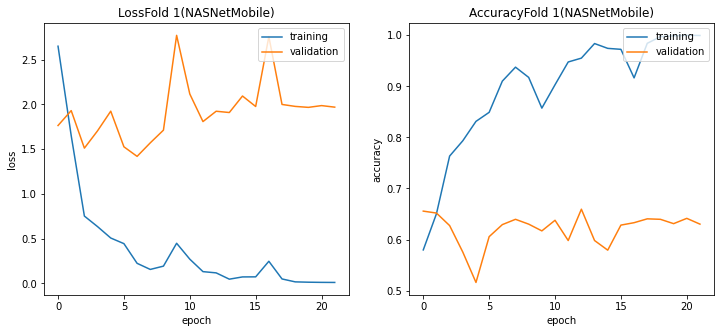

<Figure size 432x288 with 0 Axes>

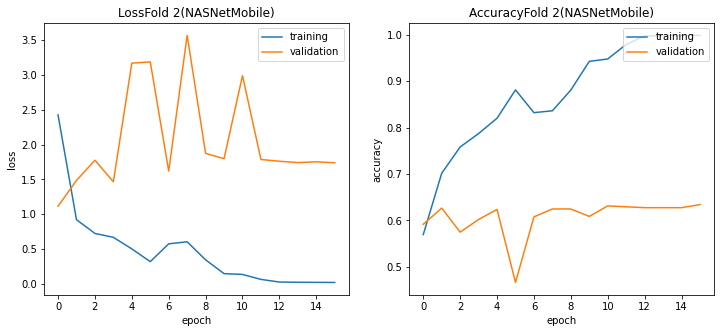

<Figure size 432x288 with 0 Axes>

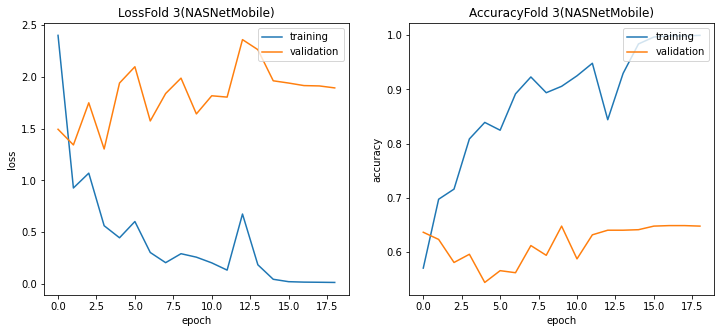

<Figure size 432x288 with 0 Axes>

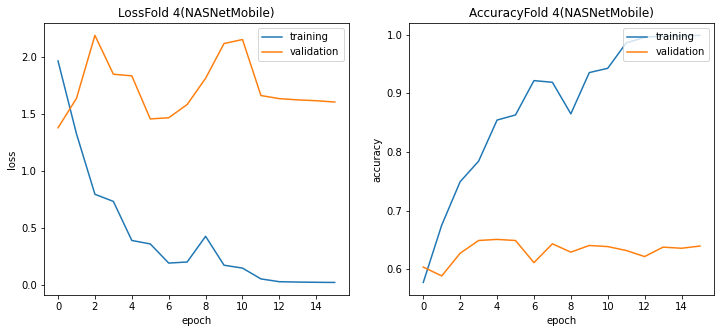

<Figure size 432x288 with 0 Axes>

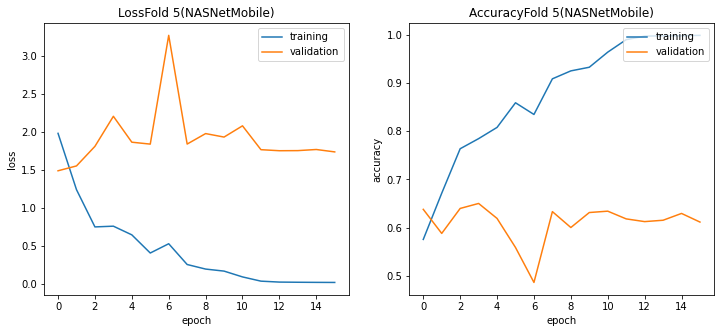

<Figure size 432x288 with 0 Axes>

In [ ]:
# ploting folds accuracy and loss curves
for i, histo in enumerate(histories):
 plot_histories(histo, "Fold "+str(i+1)+"("+ base +")")
 plt.savefig('/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelDeep/' + base + '/plt_fold'+str(i+1))

##### Metric of model

In [ ]:
print(base, "Metrique after training-------------------")
print(model_deep_metric(base))

NASNetMobile Metrique after training-------------------
([0.659433962264151, 0.6339622641509434, 0.6490566037735849, 0.6509433962264151, 0.65], [0.6854521625163827, 0.6839080459770115, 0.6994134897360704, 0.6502192982456141, 0.6596736596736597], [0.812111801242236, 0.7391304347826086, 0.7406832298136646, 0.9208074534161491, 0.8775193798449612], [0.7434257285003555, 0.7104477611940297, 0.7194570135746606, 0.7622107969151671, 0.7531603459747173], [0.6390223775544877, 0.6111847922192749, 0.6288072739685642, 0.6528123518255098, 0.6342922753813843])


---------------------------------------------------------------------------------------
### Performance model fusion
----------------------------------------------------------------------------------------------------

#### Create fusion folder

In [ ]:
import os

deep_model= ["VGG16", "VGG19", "ResNet50", "InceptionResNetV2","InceptionV3","Xception","DenseNet201","MobileNet", "NASNetMobile"]
model_tab = ["SVC", "KNN", "DecisionTree", "RandomForest", "MLP"]

for i in deep_model:
  for j in model_tab:
    os.mkdir('/content/drive/MyDrive/Data_PS3/Save_dir/result_ModelFusion/' + i + '+' + j)


#### Save fusion result in the fusion fold create

In [ ]:
for i in deep_model:
  for j in model_tab:
    save_fold_agregation(i, j)

#### Get the fusion model performance

In [ ]:
print(performance_fusion("VGG16", "SVC", option='sum'))

([0.7424528301886792, 0.7273584905660377, 0.7141509433962264, 0.7283018867924528, 0.7226415094339622], [0.7450462351387054, 0.7238335435056746, 0.7017751479289941, 0.7373333333333333, 0.7169344870210136], [0.8757763975155279, 0.8913043478260869, 0.9208074534161491, 0.8586956521739131, 0.8992248062015504], [0.8051391862955031, 0.7988865692414753, 0.796507723304231, 0.7934002869440459, 0.797799174690509], [0.7405099162492206, 0.73083062943074, 0.7322829228017063, 0.7218924731182796, 0.7289851717973593])


In [ ]:
print(model_deep_metric("VGG16"))

([0.6745283018867925, 0.6613207547169812, 0.6669811320754717, 0.6735849056603773, 0.6669811320754717], [0.7001338688085676, 0.6882430647291942, 0.6682080924855491, 0.7052341597796143, 0.6811414392059554], [0.812111801242236, 0.8090062111801242, 0.8975155279503105, 0.7950310559006211, 0.8511627906976744], [0.7519769949676491, 0.7437544610992147, 0.7660702451954937, 0.7474452554744526, 0.7567195037904892], [0.6567761995800027, 0.641151235334894, 0.6648732770120053, 0.6550122894706456, 0.6515943416502219])


In [ ]:
print(np.mean(model_tabular_metric("SVC")[0]))

0.7281132075471698


In [ ]:
A,B,C,D= metric_dataframe()

In [ ]:
A.head()

,Model_name,method,model_type,accuracy,recall,precision,f1_score,roc_auc
0,SVC,Aucun,tabular_model,0.728113,0.926641,0.601986,0.728875,0.763216
1,KNN,Aucun,tabular_model,0.728491,0.832021,0.693575,0.756356,0.727272
2,DecisionTree,Aucun,tabular_model,0.736415,0.807698,0.743242,0.774037,0.727011
3,RandomForest,Aucun,tabular_model,0.741321,0.820573,0.735486,0.775632,0.733592
4,MLP,Aucun,tabular_model,0.737736,0.858987,0.680533,0.758763,0.742780


In [ ]:
B.head(n=9)

,Model_name,method,model_type,accuracy,recall,precision,f1_score,roc_auc
0,VGG16,Aucun,Deep_model,0.668679,0.688592,0.832965,0.753193,0.653881
1,VGG19,Aucun,Deep_model,0.662642,0.680320,0.849104,0.752909,0.654945
2,ResNet50,Aucun,Deep_model,0.655660,0.682451,0.816837,0.741763,0.639332
3,InceptionResNetV2,Aucun,Deep_model,0.635660,0.655843,0.857464,0.739594,0.623081
4,InceptionV3,Aucun,Deep_model,0.635283,0.655796,0.850021,0.738192,0.615988
5,Xception,Aucun,Deep_model,0.634906,0.656420,0.840124,0.736257,0.611254
6,DenseNet201,Aucun,Deep_model,0.766981,0.799765,0.823031,0.811039,0.756475
7,MobileNet,Aucun,Deep_model,0.654906,0.672705,0.846012,0.748262,0.639870
8,NASNetMobile,Aucun,Deep_model,0.648679,0.675733,0.818050,0.737740,0.633224


In [ ]:
C.head(n=135)

,Model_name,method,model_type,accuracy,recall,precision,f1_score,roc_auc
0,VGG16+SVC+avg,avg,Fusion,0.726981,0.724985,0.889162,0.798347,0.730900
1,VGG16+KNN+avg,avg,Fusion,0.737547,0.736893,0.885128,0.803943,0.739374
2,VGG16+DecisionTree+avg,avg,Fusion,0.732264,0.732399,0.883264,0.800448,0.733572
3,VGG16+RandomForest+avg,avg,Fusion,0.739245,0.735713,0.892579,0.806259,0.744158
4,VGG16+MLP+avg,avg,Fusion,0.737358,0.736220,0.887301,0.804283,0.740126
...,...,...,...,...,...,...,...,...
130,NASNetMobile+SVC+sum,sum,Fusion,0.683396,0.693523,0.865552,0.768231,0.682571
131,NASNetMobile+KNN+sum,sum,Fusion,0.714528,0.708547,0.907785,0.794746,0.729039
132,NASNetMobile+DecisionTree+sum,sum,Fusion,0.715283,0.709861,0.905301,0.794699,0.728415
133,NASNetMobile+RandomForest+sum,sum,Fusion,0.707547,0.704080,0.901884,0.789536,0.720451


In [ ]:
D.head(149)

,Model_name,method,model_type,accuracy,recall,precision,f1_score,roc_auc
0,VGG16+SVC+avg,avg,Fusion,0.726981,0.724985,0.889162,0.798347,0.730900
1,VGG16+KNN+avg,avg,Fusion,0.737547,0.736893,0.885128,0.803943,0.739374
2,VGG16+DecisionTree+avg,avg,Fusion,0.732264,0.732399,0.883264,0.800448,0.733572
3,VGG16+RandomForest+avg,avg,Fusion,0.739245,0.735713,0.892579,0.806259,0.744158
4,VGG16+MLP+avg,avg,Fusion,0.737358,0.736220,0.887301,0.804283,0.740126
...,...,...,...,...,...,...,...,...
144,SVC,Aucun,tabular_model,0.728113,0.926641,0.601986,0.728875,0.763216
145,KNN,Aucun,tabular_model,0.728491,0.832021,0.693575,0.756356,0.727272
146,DecisionTree,Aucun,tabular_model,0.736415,0.807698,0.743242,0.774037,0.727011
147,RandomForest,Aucun,tabular_model,0.741321,0.820573,0.735486,0.775632,0.733592


In [ ]:
A.to_csv("/content/drive/MyDrive/Data_PS3/Save_dir/result/Final_metric/tabular_model_metric.csv")
B.to_csv("/content/drive/MyDrive/Data_PS3/Save_dir/result/Final_metric/Deep_model_metric.csv")
C.to_csv("/content/drive/MyDrive/Data_PS3/Save_dir/result/Final_metric/Fusion_model_metric.csv")
D.to_csv("/content/drive/MyDrive/Data_PS3/Save_dir/result/Final_metric/GLobal_metric.csv")

In [ ]:
A,B,C,D = metric_sk_dataframe()

In [ ]:
A.head(25)

,Fold,accuracy,Model
0,1,0.719811,SVC
1,2,0.737736,SVC
2,3,0.736792,SVC
3,4,0.709434,SVC
4,5,0.736792,SVC
5,1,0.741509,KNN
6,2,0.744340,KNN
7,3,0.729245,KNN
8,4,0.702830,KNN
9,5,0.724528,KNN


In [ ]:
B

,Fold,accuracy,Model
0,1,0.674528,VGG16
1,2,0.661321,VGG16
2,3,0.666981,VGG16
3,4,0.673585,VGG16
4,5,0.666981,VGG16
5,1,0.650000,VGG19
6,2,0.678302,VGG19
7,3,0.655660,VGG19
8,4,0.672642,VGG19
9,5,0.656604,VGG19


In [ ]:
C

,Fold,accuracy,Model
0,1,0.742453,VGG16+SVC+avg
1,2,0.727358,VGG16+SVC+avg
2,3,0.714151,VGG16+SVC+avg
3,4,0.728302,VGG16+SVC+avg
4,5,0.722642,VGG16+SVC+avg
...,...,...,...
670,1,0.725472,NASNetMobile+MLP+sum
671,2,0.718868,NASNetMobile+MLP+sum
672,3,0.735849,NASNetMobile+MLP+sum
673,4,0.681132,NASNetMobile+MLP+sum


In [ ]:
D

,Fold,accuracy,Model
0,1,0.742453,VGG16+SVC+avg
1,2,0.727358,VGG16+SVC+avg
2,3,0.714151,VGG16+SVC+avg
3,4,0.728302,VGG16+SVC+avg
4,5,0.722642,VGG16+SVC+avg
...,...,...,...
740,1,0.756604,MLP
741,2,0.751887,MLP
742,3,0.730189,MLP
743,4,0.703774,MLP


In [ ]:
A.to_csv("/content/drive/MyDrive/Data_PS3/Save_dir/result/Final_metric/tabular_model_metric_for_SKtest.csv")
B.to_csv("/content/drive/MyDrive/Data_PS3/Save_dir/result/Final_metric/Deep_model_metric_for_SKtest.csv")
C.to_csv("/content/drive/MyDrive/Data_PS3/Save_dir/result/Final_metric/Fusion_model_metric_for_SKtest.csv")
D.to_csv("/content/drive/MyDrive/Data_PS3/Save_dir/result/Final_metric/GLobal_metric_for_SKtest.csv")

#### Anova test to mesure the significativity of difference between model performance

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Data_PS3/Save_dir/result/Final_metric/Fusion_model_metric.csv",header=0)
df.head()

,Unnamed: 0,Model_name,method,model_type,accuracy,recall,precision,f1_score,roc_auc
0,0,VGG16+SVC+avg,avg,Fusion,0.726981,0.724985,0.889162,0.798347,0.730900
1,1,VGG16+KNN+avg,avg,Fusion,0.737547,0.736893,0.885128,0.803943,0.739374
2,2,VGG16+DecisionTree+avg,avg,Fusion,0.732264,0.732399,0.883264,0.800448,0.733572
3,3,VGG16+RandomForest+avg,avg,Fusion,0.739245,0.735713,0.892579,0.806259,0.744158
4,4,VGG16+MLP+avg,avg,Fusion,0.737358,0.736220,0.887301,0.804283,0.740126


In [ ]:
import scipy.stats as stats
import seaborn as sns

La p-value vaut: 0.99509082721641


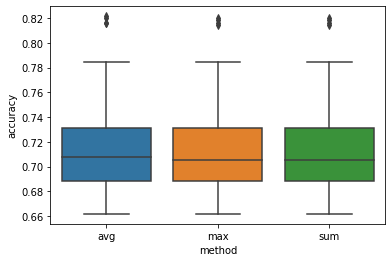

In [ ]:
fvalue, pvalue = stats.f_oneway(df['accuracy'][df['method'] == 'avg'],
                                df['accuracy'][df['method'] == 'sum'],
                                df['accuracy'][df['method'] == 'max'])
print('La p-value vaut:',pvalue)

sns.boxplot(x="method",
                y='accuracy',
                data=df)

In [ ]:
def baseline():
    model = tf.keras.Sequential([

        # TODO: Define the first convolutional layer
        tf.keras.layers.Conv2D('''TODO'''), 

        # TODO: Define the first max pooling layer
        tf.keras.layers.MaxPool2D('''TODO'''),

        # TODO: Define the second convolutional layer
        tf.keras.layers.Conv2D('''TODO'''),

        # TODO: Define the second max pooling layer
        tf.keras.layers.MaxPool2D('''TODO'''),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),

        # TODO: Define the last Dense layer to output the classification 
        # probabilities. Pay attention to the activation needed a probability
        # output
        '''TODO: Dense layer to output classification probabilities'''
    ])
    
    return cnn_model  